In [1]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import os
# Arrange GPUs to be used
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# Leaky relu implementation
def leaky_relu(x):
    return tf.nn.relu(x) - tf.nn.relu(-x * .2)
# Define generator
def generator(rnd_z, out_shape, reuse):
    global n_hidden_layers
    with tf.variable_scope('generator', reuse=reuse):
        # Generator architecture
        layer1 = tf.layers.dense(rnd_z , n_hidden_layers * 1, activation=leaky_relu)
        layer2 = tf.layers.dense(layer1, n_hidden_layers * 2, activation=leaky_relu)
        layer3 = tf.layers.dense(layer2, n_hidden_layers * 4, activation=leaky_relu)
        output = tf.layers.dense(layer3, out_shape, activation=tf.nn.tanh)
        return output

# Define discriminator (returns logits)
def discriminator(x, reuse, is_training):
    global n_hidden_layers
    global keep_prob
    with tf.variable_scope('discriminator', reuse=reuse):
        # Discriminator architecture
        layer1 = tf.layers.dense(x     , n_hidden_layers * 4, activation=leaky_relu)
        layer1 = tf.contrib.layers.dropout(layer1, keep_prob=keep_prob, is_training=is_training)
        
        layer2 = tf.layers.dense(layer1, n_hidden_layers * 2, activation=leaky_relu)
        layer2 = tf.contrib.layers.dropout(layer2, keep_prob=keep_prob, is_training=is_training)
        
        layer3 = tf.layers.dense(layer2, n_hidden_layers * 1, activation=leaky_relu)
        layer3 = tf.contrib.layers.dropout(layer3, keep_prob=keep_prob, is_training=is_training)
        
        logits = tf.layers.dense(layer3, 1, activation=None)
        return logits

In [3]:
# Parameters
n_hidden_layers = 256
input_width = 28
rnd_size_width = 10
input_size = input_width * input_width
rnd_z_size = rnd_size_width * rnd_size_width
smooth = 0.0
learning_rate = .0002
batch_size = 100
n_epoch = 300
store_size = 10
keep_prob = .3

In [4]:
mnist = input_data.read_data_sets('../data/mnist/')

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


In [5]:
# Graph
tf.reset_default_graph()
imag_plcholder = tf.placeholder(tf.float32, (None, input_size), name='image_placeholder')
fake_plcholder = tf.placeholder(tf.float32, (None, rnd_z_size), name='fake_placeholder')
is_training = tf.placeholder(tf.bool, (), name='dropout_placeholder')
g_out = generator(fake_plcholder, input_size, False)
d_logits_imag = discriminator(imag_plcholder, False, is_training)
d_logits_fake = discriminator(g_out, True, is_training)
# Losses
label_imag = tf.ones_like(d_logits_imag) * (1 - smooth) # Apply smoothing to help discriminator
label_fake = tf.zeros_like(d_logits_fake) # label is 1 for images, 0 for fake images
d_loss_imag = tf.nn.sigmoid_cross_entropy_with_logits(labels=label_imag, logits=d_logits_imag)
d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels=label_fake, logits=d_logits_fake)
d_loss_total = tf.reduce_mean(d_loss_imag+d_loss_fake)
g_label = tf.ones_like(d_logits_fake) # Generator needs to fool discriminator
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=g_label, logits=d_logits_fake))
# Optimizers
g_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='generator')
d_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator')
g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss_total, var_list=d_vars)

In [6]:
sample_arr = []
loss_arr = []
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(n_epoch):
        iter_num = mnist.train.num_examples // batch_size
        (epoch_d_loss, epoch_g_loss) = ([], [])
        for b in range(iter_num):
            # Get batch
            batch = mnist.train.next_batch(batch_size) # [batch_features, batch_labels]
            batch_images = 2 * batch[0] - 1 # Generator output is tanh, transform input similar to it.
            # Get random values
            batch_rnd = np.random.uniform(-1, 1, size=(batch_size, rnd_z_size))
            # Optimize
            _, d_loss_batch = sess.run([d_opt, d_loss_total], feed_dict={imag_plcholder:batch_images, fake_plcholder:batch_rnd, is_training:True})
            _, g_loss_batch = sess.run([g_opt, g_loss], feed_dict={fake_plcholder:batch_rnd, is_training:True})
            epoch_d_loss.append(d_loss_batch)
            epoch_g_loss.append(g_loss_batch)
        # Get loss as average of batch training losses
        loss_arr.append([np.mean(epoch_g_loss), np.mean(epoch_d_loss)])
        # Print
        print("Epoch: %4d of %d, Discriminator loss: %.4f, Generator loss: %.4f" %(e+1, n_epoch, loss_arr[-1][1], loss_arr[-1][0]))
        # Get samples
        rnd_z = np.random.uniform(-1, 1, size=(store_size, rnd_z_size))
        sample_train = sess.run(generator(fake_plcholder, input_size, True), feed_dict={fake_plcholder:rnd_z, is_training:False})
        sample_arr.append(sample_train)
    # Save model we only need generator
    saver.save(sess, '../models/v3_GAN/gen.ckpt')

Epoch:    1 of 300, Discriminator loss: 1.3999, Generator loss: 1.5304
Epoch:    2 of 300, Discriminator loss: 1.2215, Generator loss: 1.1258
Epoch:    3 of 300, Discriminator loss: 0.9874, Generator loss: 1.6377
Epoch:    4 of 300, Discriminator loss: 0.8816, Generator loss: 1.8530
Epoch:    5 of 300, Discriminator loss: 0.9655, Generator loss: 1.5780
Epoch:    6 of 300, Discriminator loss: 0.9377, Generator loss: 1.6366
Epoch:    7 of 300, Discriminator loss: 1.0182, Generator loss: 1.3613
Epoch:    8 of 300, Discriminator loss: 1.1725, Generator loss: 1.0705
Epoch:    9 of 300, Discriminator loss: 1.1102, Generator loss: 1.1459
Epoch:   10 of 300, Discriminator loss: 1.1213, Generator loss: 1.1484
Epoch:   11 of 300, Discriminator loss: 1.1372, Generator loss: 1.0736
Epoch:   12 of 300, Discriminator loss: 1.2013, Generator loss: 1.0012
Epoch:   13 of 300, Discriminator loss: 1.2123, Generator loss: 0.9806
Epoch:   14 of 300, Discriminator loss: 1.1911, Generator loss: 1.0077
Epoch:

Epoch:  117 of 300, Discriminator loss: 1.3403, Generator loss: 0.7915
Epoch:  118 of 300, Discriminator loss: 1.3396, Generator loss: 0.7798
Epoch:  119 of 300, Discriminator loss: 1.3482, Generator loss: 0.7779
Epoch:  120 of 300, Discriminator loss: 1.3399, Generator loss: 0.7894
Epoch:  121 of 300, Discriminator loss: 1.3364, Generator loss: 0.7908
Epoch:  122 of 300, Discriminator loss: 1.3394, Generator loss: 0.7896
Epoch:  123 of 300, Discriminator loss: 1.3401, Generator loss: 0.7831
Epoch:  124 of 300, Discriminator loss: 1.3412, Generator loss: 0.7853
Epoch:  125 of 300, Discriminator loss: 1.3409, Generator loss: 0.7772
Epoch:  126 of 300, Discriminator loss: 1.3428, Generator loss: 0.7805
Epoch:  127 of 300, Discriminator loss: 1.3402, Generator loss: 0.7892
Epoch:  128 of 300, Discriminator loss: 1.3392, Generator loss: 0.7857
Epoch:  129 of 300, Discriminator loss: 1.3412, Generator loss: 0.7838
Epoch:  130 of 300, Discriminator loss: 1.3379, Generator loss: 0.7993
Epoch:

Epoch:  233 of 300, Discriminator loss: 1.3618, Generator loss: 0.7504
Epoch:  234 of 300, Discriminator loss: 1.3598, Generator loss: 0.7526
Epoch:  235 of 300, Discriminator loss: 1.3597, Generator loss: 0.7538
Epoch:  236 of 300, Discriminator loss: 1.3593, Generator loss: 0.7568
Epoch:  237 of 300, Discriminator loss: 1.3579, Generator loss: 0.7561
Epoch:  238 of 300, Discriminator loss: 1.3582, Generator loss: 0.7491
Epoch:  239 of 300, Discriminator loss: 1.3551, Generator loss: 0.7591
Epoch:  240 of 300, Discriminator loss: 1.3580, Generator loss: 0.7555
Epoch:  241 of 300, Discriminator loss: 1.3594, Generator loss: 0.7470
Epoch:  242 of 300, Discriminator loss: 1.3613, Generator loss: 0.7568
Epoch:  243 of 300, Discriminator loss: 1.3583, Generator loss: 0.7599
Epoch:  244 of 300, Discriminator loss: 1.3601, Generator loss: 0.7498
Epoch:  245 of 300, Discriminator loss: 1.3593, Generator loss: 0.7506
Epoch:  246 of 300, Discriminator loss: 1.3600, Generator loss: 0.7513
Epoch:

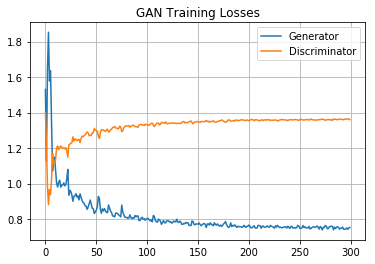

In [7]:
# Plot loss
loss_np = np.asarray(loss_arr)
plt.cla()
plt.plot(loss_np.T[0,:], label='Generator')
plt.plot(loss_np.T[1,:], label='Discriminator')
plt.grid()
plt.title('GAN Training Losses')
plt.legend()
plt.show()

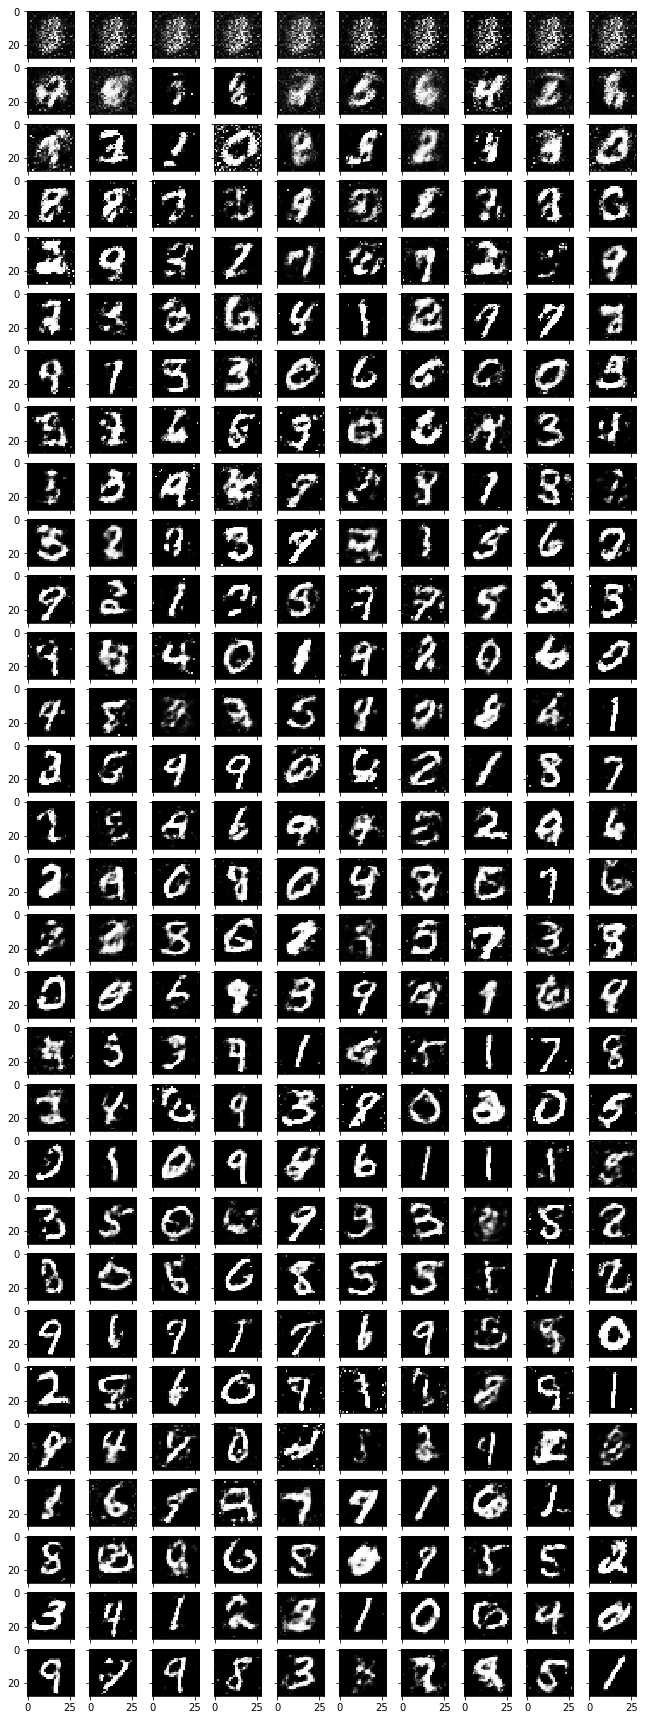

In [8]:
# Plot samples for every 10 epoch
period = 10
n_rows, n_cols = n_epoch // period, store_size
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, sharey=True, figsize=(n_cols+1,n_rows+1))
for row in range(n_rows):
    for col in range(n_cols):
        ax[row, col].imshow(sample_arr[row * period][col].reshape((28,28)), cmap='Greys_r')

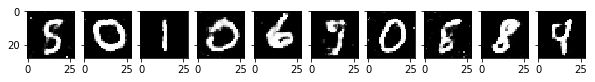

In [12]:
# Restore model to generate more images
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, '../models/v3_GAN/gen.ckpt')
    rnd_z = np.random.uniform(-1, 1, size=(store_size, rnd_z_size))
    sample = sess.run(generator(fake_plcholder, input_size, True), feed_dict={fake_plcholder:rnd_z})
    fig, ax = plt.subplots(nrows=1, ncols=store_size, sharex=True, sharey=True, figsize=(10,store_size+1))
    for col in range(store_size):
        ax[col].imshow(sample[col].reshape((28,28)), cmap='Greys_r')

** Reference **

This [GAN tutorial](https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f) is used as a reference.